<a href="https://colab.research.google.com/github/jo1jun/Vision_Transformer/blob/main/VisualizeAttentionMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [550]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

% pip install einops

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange
# tensor 연산을 간편하게 하기 위해 einops moudule import.
# reference & tutorial : http://einops.rocks/pytorch-examples.html

# Multi Head Attention Layer

In [551]:
# 기존 구조와 동일. einops 활용.
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout_ratio):
        super().__init__()

        self.d_model = d_model # embed dimension
        self.nhead = nhead # head 수
        self.head_dim = d_model // nhead # head 마다의 dimension

        # paper 보면 d_model * d_k 이런 shape 인데, 실제 구현에서는 d_model * d_model 하고 나온 것을 쪼개서 multi head self attention 에 들어가게 함.
        self.qLinear = nn.Linear(d_model, d_model) # query lineqr
        self.kLinear = nn.Linear(d_model, d_model) # key linear
        self.vLinear = nn.Linear(d_model, d_model) # value linear
        self.oLinear = nn.Linear(d_model, d_model) # output linear

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]
        query_len = query.shape[1]
        value_len = key_len = key.shape[1]

        # query: [batch_size, query_len, d_model]
        # key: [batch_size, key_len, d_model]
        # value: [batch_size, value_len, d_model]
 
        Q = self.qLinear(query)
        K = self.kLinear(key)
        V = self.vLinear(value)

        # Q: [batch_size, query_len, d_model]
        # K: [batch_size, key_len, d_model]
        # V: [batch_size, value_len, d_model]

        # d_model = nhead * head_dim
        # head 수로 distribute
        Q = rearrange(Q, 'b l (h d) -> b h l d', h=self.nhead)
        K = rearrange(K, 'b l (h d) -> b h l d', h=self.nhead)
        V = rearrange(V, 'b l (h d) -> b h l d', h=self.nhead)

        # Q: [batch_size, nhead, query_len, head_dim]
        # K: [batch_size, nhead, key_len, head_dim]
        # V: [batch_size, nhead, value_len, head_dim]

        # attention weight 계산
        weight = torch.matmul(Q, rearrange(K, 'b h l d -> b h d l')) / np.sqrt(self.head_dim)

        # weight: [batch_size, nhead, query_len, key_len]

        attention = torch.softmax(weight, dim=-1) # TODO : softmax -1?

        # attention: [batch_size, nhead, query_len, key_len]

        # context vector 계산
        c = torch.matmul(self.dropout(attention), V)

        # c: [batch_size, nhead, query_len, head_dim]

        # reshape & concat
        c = rearrange(c, 'b h l d -> b l (h d)')

        # c: [batch_size, query_len, d_model]

        output = self.oLinear(c)

        # output: [batch_size, query_len, d_model]

        return output, attention

# Position-wise Feed Forward Layer

In [552]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, d_model, ff_dim, dropout_ratio):
        super().__init__()

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, d_model]
      
        x = self.dropout(nn.functional.gelu(self.linear1(x))) # relu -> gelu

        # x: [batch_size, seq_len, ff_dim]

        x = self.linear2(x)

        # x: [batch_size, seq_len, d_model]

        return x

# Encoder Layer

In [553]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):

        # src: [batch_size, src_len, d_model]

        _src = self.layerNorm1(src) # layer norm 순서 바뀜.

        # self attention 이므로 query, key, value 전부 동일
        _src, a = self.multiHeadAttentionLayer(_src, _src, _src)

        src = src + self.dropout(_src)

        _src = self.layerNorm2(src)

        # src: [batch_size, src_len, d_model]

        _src = self.positionWiseFeedForward(_src)

        # dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized
        src = src + self.dropout(_src)

        # src: [batch_size, src_len, d_model]

        return src, a

# Encoder

In [554]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()

        # EncoderLayer 을 n_layers 만큼 반복.
        self.layers = nn.ModuleList([EncoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

    def forward(self, src):

        # src: [batch_size, src_len]

        for layer in self.layers:
            src, a = layer(src)

        # src: [batch_size, src_len, d_model]

        return src, a

# Patch maker & Flatten

In [555]:
# 우선은 image, patch 모두 정사각형 shpae 임을 가정.

class ImageEmbedding(nn.Module):
  def __init__(self, channel, patch_size, D):
    super().__init__()
    # image 를 patch 단위로 나눈 뒤 [batch_size, patch 개수, patch크기*channel수] 로 shape 만들기
    self.rearrange = Rearrange('b c (num_w p1) (num_h p2) -> b (num_w num_h) (p1 p2 c) ', p1=patch_size, p2=patch_size)
    # 임베딩 작업 [batch_size, patch 개수, patch크기*chaennel수] -> [batch_size, patch 개수, embed_dim]
    self.linear = nn.Linear(channel*patch_size*patch_size, D)

    self.cls_token = nn.Parameter(torch.randn(1, 1, D))

  def forward(self, image):

    b, c, w, h = image.shape

    # image: [batch_size, channel, width, height]

    # num_w = w / p1
    # num_h = h / p2
    # n = num_w * num_h = (w*h) / (p1*p2)
    flatten_patches = self.rearrange(image)
    embedded_patches = self.linear(flatten_patches)
    
    cls_tokens = repeat(self.cls_token, 'b n d -> (b repeat) n d', repeat=b) # class token 추가.
    embedded_patches = torch.cat((cls_tokens, embedded_patches), dim=1)

    return embedded_patches




# Token & Positional Embedding

In [556]:
class TokPosEmbedding(nn.Module):
  def __init__(self, c, p, d_model, dropout_ratio):
    super().__init__()
    self.tokEmbedding = ImageEmbedding(c, p, d_model)
    self.posEmbedding = nn.Embedding(100, d_model) # cos & sin positional encoding 대신, learnable positional embedding 으로 구현. (max patch 수 100)
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):

    # src: [batch_size, width, height, channel]

    src = self.tokEmbedding(src)

    # src: [batch_size, src_len, d_model]

    batch_size = src.shape[0]
    src_len = src.shape[1]

    # 0 ~ src_len 등차 수열값 을 bactch 한개와 동일한 shape으로 생성 (positional embedding)
    pos = torch.arange(0, src_len, dtype=dtype) # pos: [src_len]
    pos = repeat(pos, 'l -> b l', b=batch_size).to(device) # pos: [batch_size, src_len]

    src = self.dropout(src * float(np.sqrt(self.d_model)) + self.posEmbedding(pos))
    # Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings

    # src: [batch_size, src_len, d_model]

    return src

# VisionTransformer

In [557]:
class VisionTransformer(nn.Module):
    def __init__(self, c, p, d_model, n_layers, nhead, ff_dim, dropout_ratio, output_dim):
        super().__init__()

        self.encEmbedding = TokPosEmbedding(c, p, d_model, dropout_ratio)
        self.encoder = Encoder(d_model, n_layers, nhead, ff_dim, dropout_ratio)
        self.layerNorm = nn.LayerNorm(d_model)
        self.linear = nn.Linear(d_model, output_dim) 

    def forward(self, src):
        
        # src: [batch_size, src_len]

        src = self.encEmbedding(src)

        enc_src, a = self.encoder(src)

        # enc_src: [batch_size, src_len, d_model]

        # classification head

        enc_src = reduce(enc_src, 'b l d -> b d', 'mean') # 모든 sequence 평균.

        # enc_src: [batch_size, d_model]

        enc_src = self.layerNorm(enc_src)

        output = self.linear(enc_src)

        # output: [batch_size, output_dim]

        return output, a


# MNIST Dataset & DataLoader

In [558]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [559]:
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5), (0.5))
            ])

mnist_train = dset.MNIST('dataset', train=True, download=True,
                             transform=transform)

mnist_test = dset.MNIST('dataset', train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(mnist_train, batch_size=64)
loader_test = DataLoader(mnist_test, batch_size=64)

# Trainer

In [560]:
def trainer(model, optimizer, epochs):

  model = model.to(device)
  loss_history = []
  loss_val_history = []
  for e in range(epoch):
    model.train()
    running_loss = 0.0
    for iters, (batch_x, batch_t) in enumerate(loader_train):

      batch_x = batch_x.to(device)
      batch_t = batch_t.to(device)

      scores, a = model(batch_x)

      # scores  : [batch_size , output_dim]
      # batch_t : [batch_size]

      loss = nn.functional.cross_entropy(scores, batch_t)
      running_loss += loss

      optimizer.zero_grad()

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # gradient clippling

      optimizer.step()

      if iters % 100 == 99:
        print('epoch[%d/%d] iter[%d/%d] loss = %.4f' % (e+1, epochs, iters, len(loader_train), loss.item()))
        running_loss /= 100
        loss_history.append(running_loss)
        
        model.eval()
        with torch.no_grad():
          running_loss_val = 0.0

          for j, (x_val, y_val) in enumerate(loader_val):
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            scores_val, _ = model(x_val)
            loss_val = nn.functional.cross_entropy(scores_val, y_val)
            running_loss_val += loss_val

          running_loss_val /= len(loader_val)
          loss_val_history.append(running_loss_val)

        running_loss = 0.0
  
  plt.plot(range(len(loss_history)), loss_history, label='train_loss')
  plt.plot(range(len(loss_val_history)), loss_val_history, label='val_loss')
  plt.legend()
  

# Checker

In [561]:
def checker(loader, model):

    model.eval()
    with torch.no_grad():
      correct_num = 0
      for iters, (batch_x, batch_t) in enumerate(loader):

        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)

        predict, _ = model(batch_x)
        _, predict = predict.max(1)

        correct_num += (predict == batch_t).sum()
        
    return correct_num

In [562]:
channel = 1
patch_size = 4

d_model = 64
n_layers = 6
nhead = 4
ff_dim = 1024
dropout_ratio = 0.2
output_dim = 10

epoch = 10

epoch[1/10] iter[99/938] loss = 1.5374
epoch[1/10] iter[199/938] loss = 0.9746
epoch[1/10] iter[299/938] loss = 0.5375
epoch[1/10] iter[399/938] loss = 0.4688
epoch[1/10] iter[499/938] loss = 0.2704
epoch[1/10] iter[599/938] loss = 0.1914
epoch[1/10] iter[699/938] loss = 0.3788
epoch[1/10] iter[799/938] loss = 0.1894
epoch[1/10] iter[899/938] loss = 0.1072
epoch[2/10] iter[99/938] loss = 0.1352
epoch[2/10] iter[199/938] loss = 0.1127
epoch[2/10] iter[299/938] loss = 0.1066
epoch[2/10] iter[399/938] loss = 0.3326
epoch[2/10] iter[499/938] loss = 0.1523
epoch[2/10] iter[599/938] loss = 0.1286
epoch[2/10] iter[699/938] loss = 0.3174
epoch[2/10] iter[799/938] loss = 0.0851
epoch[2/10] iter[899/938] loss = 0.0647
epoch[3/10] iter[99/938] loss = 0.0771
epoch[3/10] iter[199/938] loss = 0.0450
epoch[3/10] iter[299/938] loss = 0.0922
epoch[3/10] iter[399/938] loss = 0.3374
epoch[3/10] iter[499/938] loss = 0.1805
epoch[3/10] iter[599/938] loss = 0.0748
epoch[3/10] iter[699/938] loss = 0.2136
epo

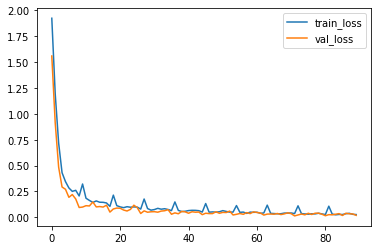

In [563]:
model = VisionTransformer(channel, patch_size, d_model, n_layers, nhead, ff_dim, dropout_ratio, output_dim)
optimizer = torch.optim.Adam(model.parameters())

trainer(model, optimizer, epoch)

# Accuracy

In [564]:
correct_num = checker(loader_train, best_model)
acc = float(correct_num) / len(mnist_train)
print('train accuracy %.3f%%' % (acc * 100))

correct_num = checker(loader_test, best_model)
acc = float(correct_num) / len(mnist_test)
print('test accuracy %.3f%%' % (acc * 100))

train accuracy 99.023%
test accuracy 98.330%


# Visualize Attention Map

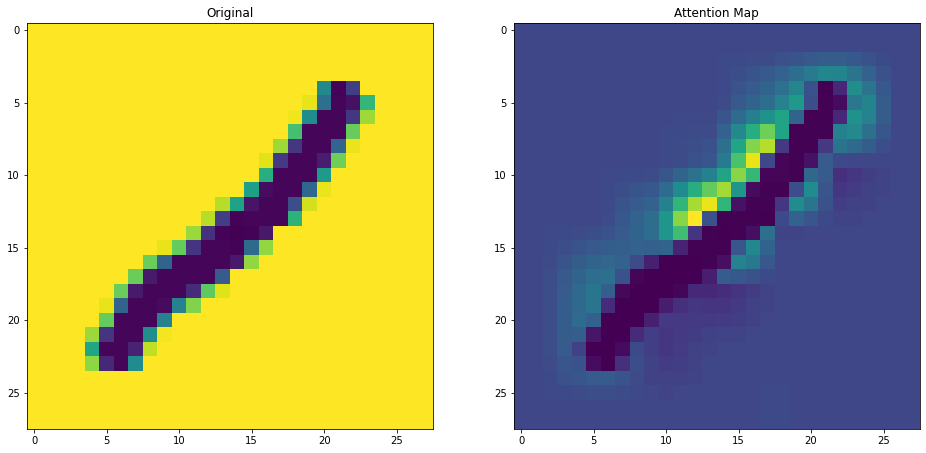

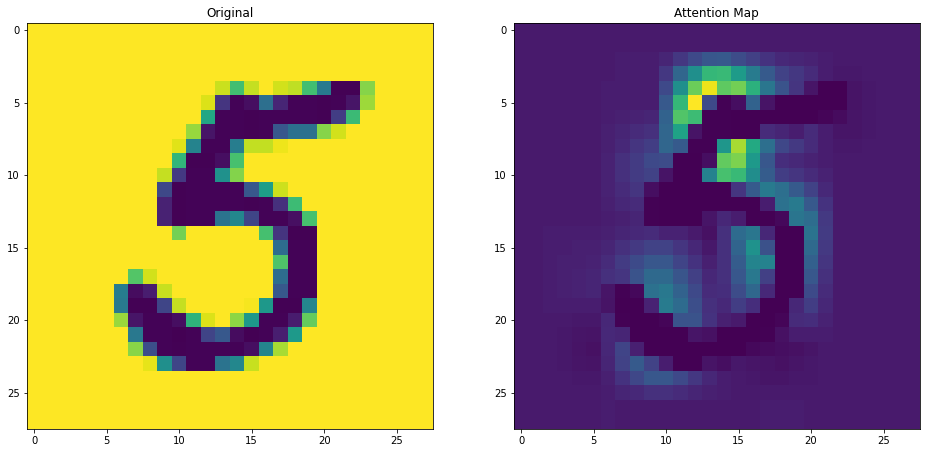

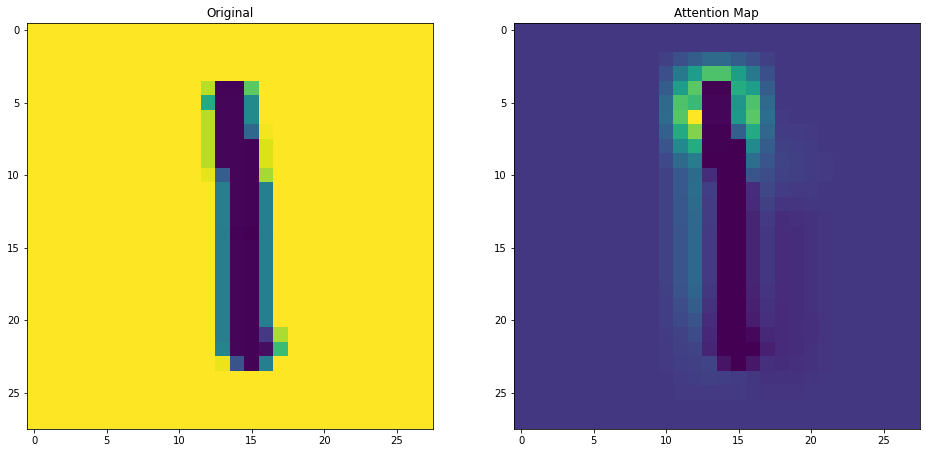

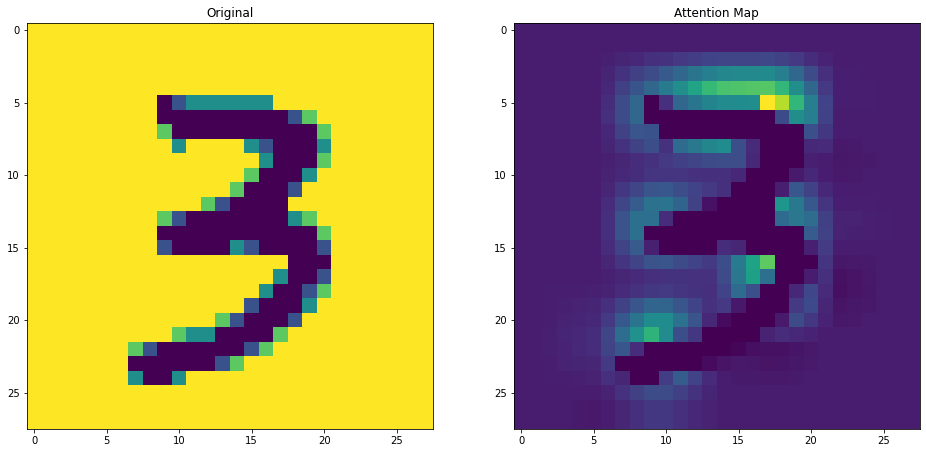

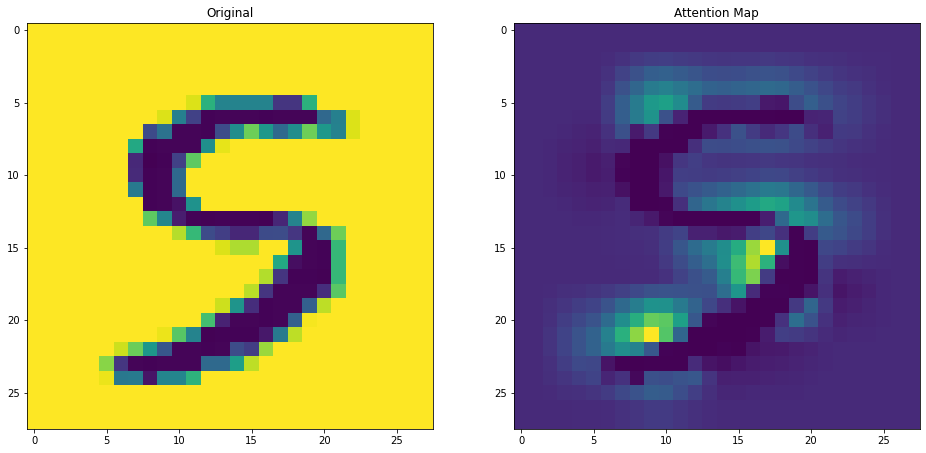

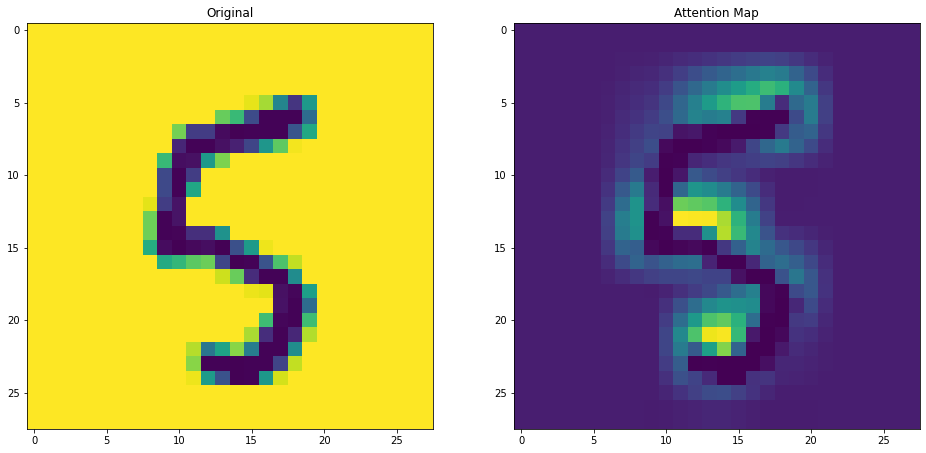

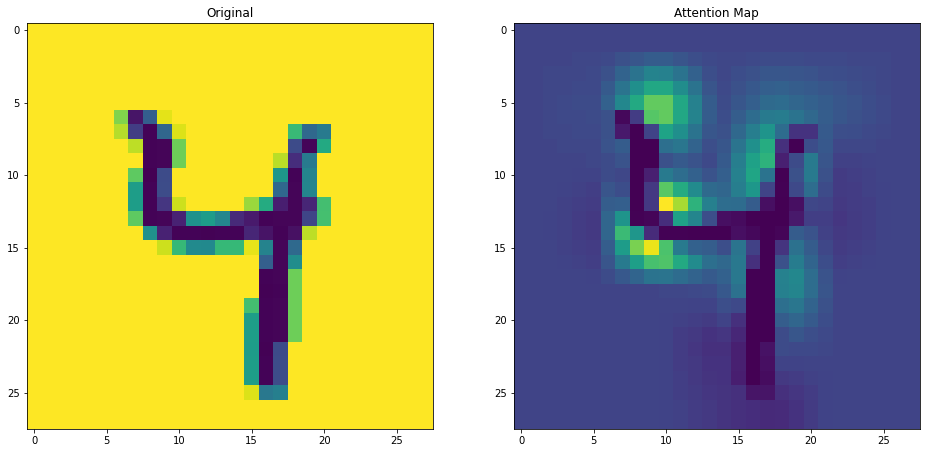

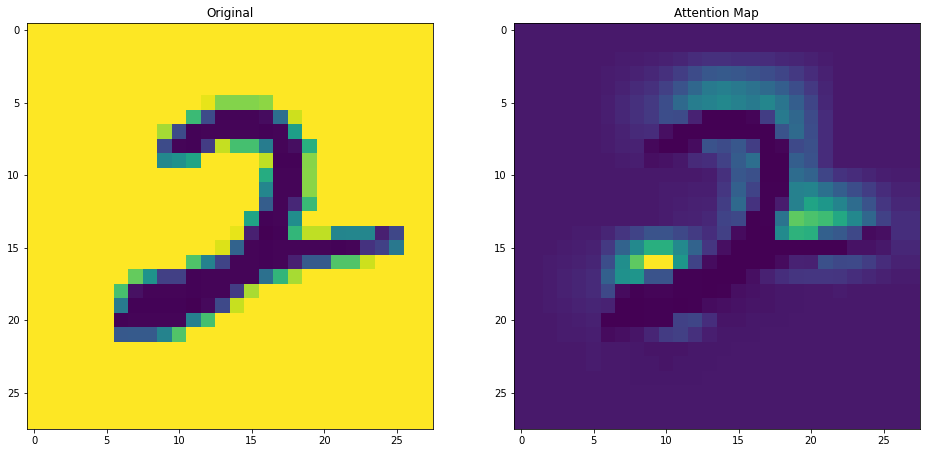

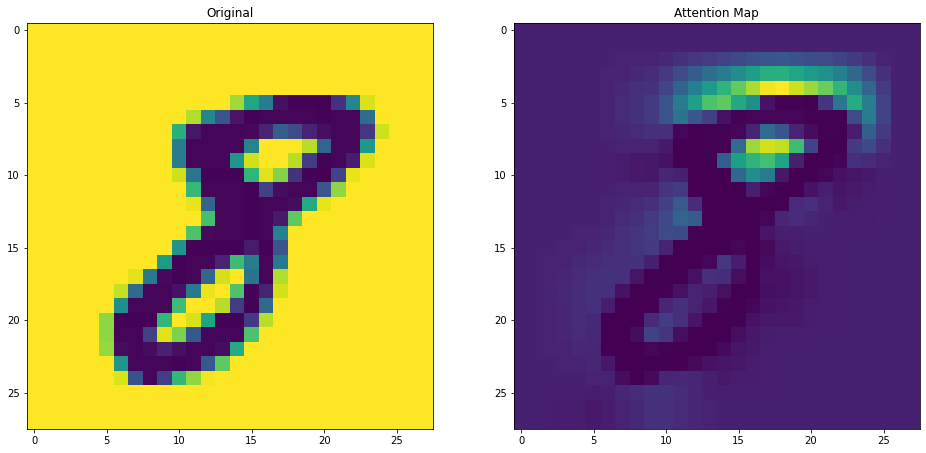

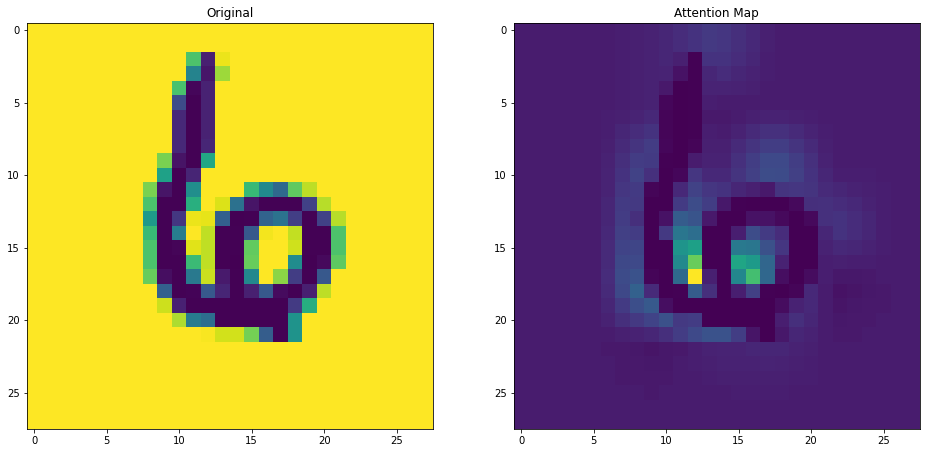

In [565]:
# reference : https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb

import cv2

idxs = np.random.choice(range(len(mnist_test.data)), 10, False)
for idx in idxs:
  im = mnist_test.data[idx]
  im = 255 - im

  _, attention = model(im.unsqueeze(0).unsqueeze(1).to(device, torch.float))
  attention = attention.cpu().detach()
  attention = reduce(attention, 'b h len1 len2 -> len1 len2', 'mean')

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_att = torch.eye(attention.size(1))
  aug_attention = attention + residual_att
  aug_attention = aug_attention / aug_attention.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_attention.size())
  joint_attentions[0] = aug_attention[0]

  for n in range(1, aug_attention.size(0)):
      joint_attentions[n] = torch.matmul(aug_attention[n], joint_attentions[n-1])

  # Attention from the output token to the input space.
  v = joint_attentions
  grid_size = int(np.sqrt(aug_attention.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), im.shape)[..., np.newaxis]

  result = (mask.squeeze() * im.numpy()).astype("uint8")

  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

  ax1.set_title('Original')
  ax2.set_title('Attention Map')
  _ = ax1.imshow(im)
  _ = ax2.imshow(result)